## 모델 동작에 필요한 사전 준비

In [1]:
! pip install tensorflow_datasets

In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow.keras import Model, layers

2023-06-21 09:45:47.519945: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-21 09:45:47.522086: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-21 09:45:47.567065: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-21 09:45:47.568252: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 09:45:48.266472: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2023-06-21 09:45:49.991871: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## 데이터 불러오기 및 전처리

In [4]:
# 이번 GAN 실습에 활용될 MNIST 데이터를 다운로드한 후,
# 불러온 데이터를 Training용과 Testing용으로 나누는 과정
# 모든 이미지 데이터의 크기는 28 x 28 x 1 (흑백)

dataset = tfds.load('mnist', split = 'train')
batch_size = 1024
train_data = dataset.map(lambda data: tf.cast(data['image'], tf.float32) / 255.).batch(batch_size)

## GAN 구현

### GAN의 생성자 (Generator) 구현

In [5]:
# GAN의 생성자 (Generator)

class Generator(Model):
    def __init__(self, latent_dim):
        super().__init__()

        # 2D convolutional layer의 역연산에 해당하는 transposed 2D convolutional layer의 경우,
        # same padding을 적용하고 strides 값을 2로 할 경우 이미지의 크기가 두 배로 확장되는 효과!
        self.latent_dim = latent_dim
        self.generator = tf.keras.Sequential([

            layers.Dense(7 * 7 * 32, activation = 'relu'),                                          # (batch_size, 7 * 7 * 32) , input_shape = (latent_dim, )
            layers.Reshape((7, 7, 32)),                                                             # (batch_size, 7, 7, 32)
            layers.Conv2DTranspose(64, 3, strides = 2, padding = 'same', activation = 'relu'),      # (batch_size, 14, 14, 64)
            layers.Conv2DTranspose(32, 3, strides = 2, padding = 'same', activation = 'relu'),      # (batch_size, 28, 28, 32)
            layers.Conv2DTranspose(1, 3, strides = 1, padding = 'same', activation = 'sigmoid')     # (batch_size, 28, 28, 1)
        ])

    def call(self, z):
        return self.generator(z)

### GAN의 판별자 (Discriminator) 구현

In [6]:
# GAN의 판별자 (Discriminator)

class Discriminator(Model):
    def __init__(self, latent_dim):
        super().__init__()

        # 2D convolutional layer에서 same padding을 적용하고 strides 값을 2로 할 경우 이미지의 크기가 절반으로 줄어드는 효과!
        self.latent_dim = latent_dim
        self.discriminator = tf.keras.Sequential([
            layers.Conv2D(32, 3, strides = 2, activation = 'relu', padding = 'same', input_shape = (28, 28, 1)),    # (batch_size, 14, 14, 32)
            layers.Conv2D(64, 3, strides = 2, activation = 'relu', padding = 'same'),                               # (batch_size, 7, 7, 64)
            layers.Flatten(),                                                                                       # (batch_size, 7 * 7 * 64)
            layers.Dense(1)                                                                                         # (batch_size, )
        ])

    def call(self, x):
        return self.discriminator(x)

### GAN 구조 정의

In [7]:
# Hyperparameters

n_epochs = 200
latent_dim = 10
log_interval = 20

In [8]:
# GAN의 생성자와 판별자
generator = Generator(latent_dim)
discriminator = Discriminator(latent_dim)


# Optimizer 정의
optimizer_g = tf.keras.optimizers.Adam(1e-3)
optimizer_d = tf.keras.optimizers.Adam(1e-3)

## Training

### Loss Function 정의

In [9]:
# Loss function은 binary cross entropy (BCE)로 정의

loss = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [10]:
def train_step(inputs):
    noises = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as tape_g, tf.GradientTape() as tape_d:
        # noises: random noise 분포에서 sample된 벡터
        # x: noises로부터 생성된 MNIST 이미지
        # real_output: 실제 MNIST 이미지 판별 결과
        # fake_output: GAN의 생성자가 생성한 MNIST 이미지의 판별 결과

        x = generator(noises)  # 가짜이미지 / inputs -> 진짜이미지
        
        real_output = discriminator(inputs)  # discriminator -> 진짜라고 맞혀야 함 (1)
        fake_output = discriminator(x)
        # 1. discriminator -> fake output 0이라고 예측해야됨
        # 2. generator -> discriminator 속여야함 -> 1이 나오길 원해야 함
        
        # Generator loss와 discriminator loss 계산
        loss_g = loss(tf.ones_like(fake_output), fake_output)
        loss_d = loss(tf.ones_like(real_output), real_output) + loss(tf.zeros_like(fake_output), fake_output)

    # GAN을 구성하는 생성자와 판별자의 gradient 값들을 계산하는 과정
    grads_g = tape_g.gradient(loss_g, generator.trainable_variables)
    grads_d = tape_d.gradient(loss_d, discriminator.trainable_variables)

    # 계산된 gradient 값들을 기반으로 GAN의 생성자와 판별자를 optimize하는 과정
    optimizer_g.apply_gradients(zip(grads_g, generator.trainable_variables))
    optimizer_d.apply_gradients(zip(grads_d, discriminator.trainable_variables))

    return loss_g, loss_d

In [11]:
# 실제 Training 과정

for epoch in range(1, n_epochs + 1):
    total_loss_g, total_loss_d = 0, 0

    for x in train_data:
        loss_g, loss_d = train_step(x)
        total_loss_g += loss_g
        total_loss_d += loss_d

    if epoch % log_interval == 0:
        print(f'Epoch {epoch:3d} - Generator loss: {total_loss_g:.2f}, Discriminator loss: {total_loss_d:.2f}')

2023-06-21 09:45:50.302748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-06-21 09:45:50.303600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]


Epoch  20 - Generator loss: 158.52, Discriminator loss: 31.40
Epoch  40 - Generator loss: 100.31, Discriminator loss: 53.28
Epoch  60 - Generator loss: 80.85, Discriminator loss: 61.04
Epoch  80 - Generator loss: 88.01, Discriminator loss: 54.39
Epoch 100 - Generator loss: 71.40, Discriminator loss: 63.80
Epoch 120 - Generator loss: 72.85, Discriminator loss: 65.11
Epoch 140 - Generator loss: 69.35, Discriminator loss: 63.53
Epoch 160 - Generator loss: 70.41, Discriminator loss: 64.50
Epoch 180 - Generator loss: 69.49, Discriminator loss: 65.59
Epoch 200 - Generator loss: 62.16, Discriminator loss: 69.59


## Testing

### 생성자 동작 확인

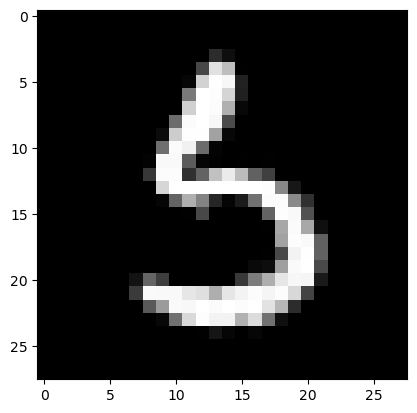

In [12]:
# 학습된 GAN 모델의 생성자로 MNIST 이미지 Sampling 및 시각화

noise = tf.random.normal([1, latent_dim])
x = generator(noise)
plt.imshow(x[0, :, :, 0], cmap = 'gray')

### 학습된 GAN 모델로 MNIST 이미지 생성

In [13]:
# 여러 개의 MNIST 이미지들을 Sampling하는 함수 정의
# n * n 정사각형 배치의 MNIST 이미지 생성 및 출력

def plot_latent_images(n, digit_size = 28):
    image_width = digit_size * n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i in range(n):
        for j in range(n):
            noise = tf.random.normal([1, latent_dim])
            x = generator(noise)
            image[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size] = x[0, :, :, 0]

    plt.figure(figsize = (10, 10))
    plt.imshow(image, cmap = 'Greys_r')
    plt.axis('Off')
    plt.show()

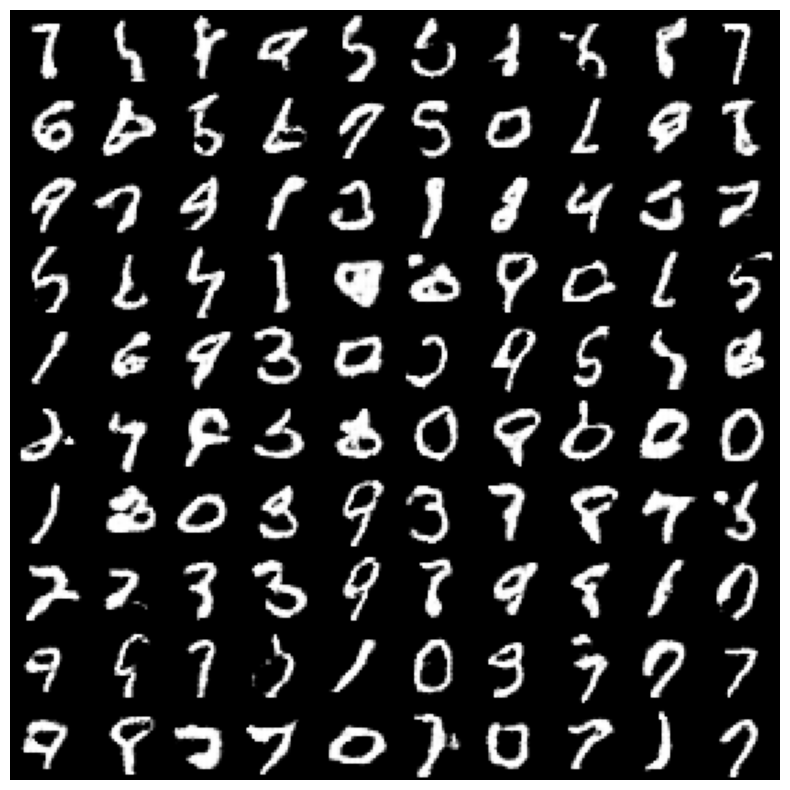

In [14]:
# MNIST 이미지 생성
# 여기서는 10 * 10 = 100개의 MNIST 이미지 생성

plot_latent_images(10)